## Demo 1: Spin-domain representation based simulation

This notebook provides examples of how to use functions to simulate RF pulse using spin-domain representations:
1. simulation of one spin with RF pulse
2. simulation of a group of spins with RF pulse

---

For a single spin, one function is provided for simulation of spin-domain parameters $(\alpha,\beta)$ for the `Spin` object
- `alpha,beta = spinorsim_spin(spin, Nt, dt, rf, gr, device)`

For a group of spins, two functions are provided for simulation of spin-domain parameters for `SpinArray` object
- `alpha,beta = spinorsim_c(spins, Nt, dt, rf, gr, device)`, returns the simulation results in complex numbers
- `alpha_real,alpha_imag,beta_real,beta_imag = spinorsim(spins, Nt, dt, rf, gr, device)`, returns the simulation results in real numbers, which is also efficient for calculating jacobians with auto-differentiation

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import sys
# sys.path.append('.../Multid_RF_SpinDomain/src') # may need to add your path 

In [2]:
# ------ select the device ------
# device = torch.device('cuda:0')    # if GPU is available
device = torch.device('cpu')       # CPU is still ok for this demo

In [3]:
from sdrf import mri
from sdrf.mrsim import SpinDomain

### An example RF pulse for later simulation

In [4]:
# Example RF pulse, we use the sinc as an example
def demo_pulse(device):
    '''a simple sinc form pulse, without windowing'''
    
    Nt = 400 
    dt = 0.01 # ms
    t0 = 100 # time parameter for a sinc pulse
    b1 = 6*1e-3*torch.special.sinc((torch.arange(Nt)-200)/t0)


    # dt = 0.04    # ms
    # b1 = [-1.4346e-04, -1.8998e-04, -2.3777e-04, -2.9053e-04, -3.4560e-04,
    #     -4.0329e-04, -4.6184e-04, -5.2065e-04, -5.7804e-04, -6.3292e-04,
    #     -6.8354e-04, -7.2850e-04, -7.6596e-04, -7.9435e-04, -8.1183e-04,
    #     -8.1680e-04, -8.0747e-04, -7.8235e-04, -7.3986e-04, -6.7871e-04,
    #     -5.9765e-04, -4.9571e-04, -3.7209e-04, -2.2626e-04, -5.7907e-05,
    #      1.3293e-04,  3.4600e-04,  5.8069e-04,  8.3609e-04,  1.1110e-03,
    #      1.4038e-03,  1.7127e-03,  2.0355e-03,  2.3697e-03,  2.7125e-03,
    #      3.0608e-03,  3.4112e-03,  3.7603e-03,  4.1041e-03,  4.4387e-03,
    #      4.7602e-03,  5.0643e-03,  5.3472e-03,  5.6048e-03,  5.8334e-03,
    #      6.0297e-03,  6.1906e-03,  6.3137e-03,  6.3968e-03,  6.4387e-03,
    #      6.4387e-03,  6.3968e-03,  6.3137e-03,  6.1906e-03,  6.0297e-03,
    #      5.8334e-03,  5.6048e-03,  5.3472e-03,  5.0643e-03,  4.7602e-03,
    #      4.4387e-03,  4.1041e-03,  3.7603e-03,  3.4112e-03,  3.0608e-03,
    #      2.7125e-03,  2.3697e-03,  2.0355e-03,  1.7127e-03,  1.4038e-03,
    #      1.1110e-03,  8.3609e-04,  5.8069e-04,  3.4600e-04,  1.3293e-04,
    #     -5.7907e-05, -2.2626e-04, -3.7209e-04, -4.9572e-04, -5.9765e-04,
    #     -6.7871e-04, -7.3986e-04, -7.8235e-04, -8.0747e-04, -8.1680e-04,
    #     -8.1183e-04, -7.9435e-04, -7.6596e-04, -7.2850e-04, -6.8354e-04,
    #     -6.3292e-04, -5.7804e-04, -5.2065e-04, -4.6184e-04, -4.0329e-04,
    #     -3.4560e-04, -2.9053e-04, -2.3777e-04, -1.8998e-04, -1.4346e-04] # SLR
    # Nt = len(b1)
    # b1 = torch.tensor(b1)
    

    # ----------------------------------------
    
    # RF waveform, (2,Nt), (real;imag) channels, unit: mT
    rf = torch.zeros(2,Nt)
    rf[0] = b1 # mT

    # Gradient, (3,Nt), X,Y,Z channels, unit: mT/m
    gr = torch.zeros(3,Nt)
    gr[2] = 4.7081  # mT/m
    
    rf = rf.to(device)    
    gr = gr.to(device)
    return rf,gr,dt,Nt

rf,gr,dt,Nt = demo_pulse(device)
(rf.shape, gr.shape, Nt, dt)
# pulse = mri.Pulse.example_slr_pulse(device=device)

(torch.Size([2, 400]), torch.Size([3, 400]), 400, 0.01)

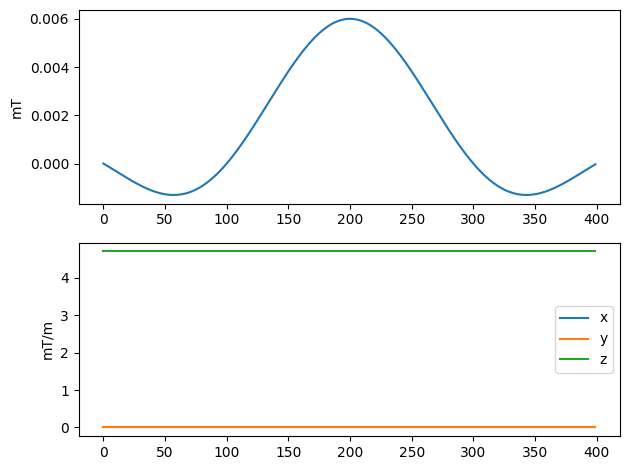

In [35]:
# Plot
fig = plt.figure()

ax = plt.subplot(211)
ax.plot(rf[0])
ax.set_ylabel('mT')

ax = plt.subplot(212)
[ax.plot(gr[ch],label=lb) for ch,lb in zip(range(3),['x','y','z'])]
ax.legend()
ax.set_ylabel('mT/m')

plt.tight_layout()
plt.show()

### Simulation of a single spin with RF pulse

In [5]:
# Spin objects
spin = mri.Spin(loc=[0,0,0], device=device)

# Simulation of spin-domain parameters
alpha,beta = SpinDomain.spinorsim_spin(spin, Nt=Nt, dt=dt, rf=rf, gr=gr, device=device)
print((alpha,beta))

(tensor(0.7499+0.j), tensor(0.+0.6616j))


### Simulation of a number of spins with RF pulse

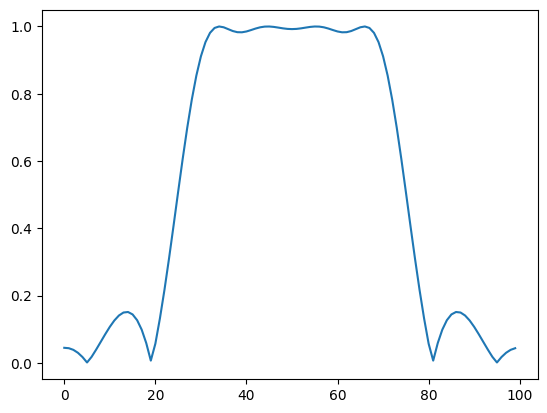

In [6]:
# Object of a number of spins 
spins = mri.SpinGrid(
    fov=[1,1,1],       # (1,1,1) cm in X,Y,Z
    dim=[1,1,100],     # define 100 spins along the z-direction
    device=device)

# Simulation of spin-domain parameters
alpha,beta = SpinDomain.spinorsim_c(spins, Nt=Nt, dt=dt, rf=rf, gr=gr, device=device)

# Plot of the simulated profile from alpha,beta
Mxy = torch.abs(alpha.conj()*beta*2).cpu().numpy()
fig = plt.figure()
plt.plot(Mxy)
plt.show()
